In [130]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [54]:
mura_Dir = "MURA-v1.1/"
train_imgs_path=pd.read_csv(mura_Dir+'train_image_paths.csv',names=["Train Dataset"])
train_labels=pd.read_csv(mura_Dir+'train_labeled_studies.csv',names=["Train Labeled Studies","label"])
test_imgs_path=pd.read_csv(mura_Dir+'valid_image_paths.csv',names=["Test Dataset"])
test_labels=pd.read_csv(mura_Dir+'valid_labeled_studies.csv',names=["Test Labeled Studies","label"])

In [55]:
train_imgs_path=train_imgs_path.sort_values(by=['Train Dataset'])
train_labels=train_labels.sort_values(by=['Train Labeled Studies'])
test_imgs_path=test_imgs_path.sort_values(by=['Test Dataset'])
test_labels=test_labels.sort_values(by=['Test Labeled Studies'])

In [56]:
test_labels['Body Part']=test_labels['Test Labeled Studies'].apply(lambda x: str(x.split('/')[2])[3:])
test_labels['Study Type']=test_labels['Test Labeled Studies'].apply(lambda x: str(x.split('/')[4])[:6])
test_labels['p']=test_labels['Test Labeled Studies'].apply(lambda x: str(x.split('/')[3])[:20])


In [57]:
train_labels['Body Part']=train_labels['Train Labeled Studies'].apply(lambda x: str(x.split('/')[2])[3:])
train_labels['Study Type']=train_labels['Train Labeled Studies'].apply(lambda x: str(x.split('/')[4])[:6])
train_labels['p']=train_labels['Train Labeled Studies'].apply(lambda x: str(x.split('/')[3])[:20])


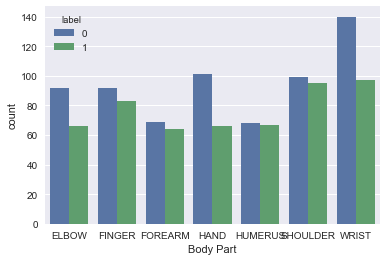

In [58]:
import seaborn as sns
sns.countplot(data=test_labels,x='Body Part',hue='label')

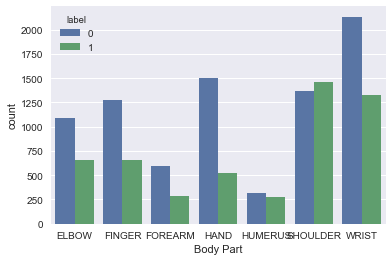

In [59]:
sns.countplot(data=train_labels,x='Body Part',hue='label')

In [60]:
import glob
import cv2
import os 

In [61]:
def fileImagesOfStudy(path):
    img_dir = path # Enter Directory of all images 
    data_path = os.path.join(img_dir,'*g')
    files = glob.glob(data_path)
    data = []
    i=0
    for f1 in files:
        i=i+1
        img = cv2.imread(f1)
        data.append(img)
           
    return data

In [62]:
import matplotlib.pyplot as plt


In [63]:
def show_images(images, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.grid(False)

    plt.show()

In [131]:
def stretching_Data(files_,dim):
    stretch=[]
    for e in tqdm(range(0,len(files_))):
        f=files_.iloc[e][0]
        dd=fileImagesOfStudy(f)
        for n in range(0,len(dd)):
            stretch.append(cv2.resize(dd[n],dsize=dim))
               
    return stretch

In [132]:
def stretching_Labels(labels_):
    labels=[]
    for e in tqdm(range(0,len(labels_))):
        l=labels_.iloc[e]['label']
        f=labels_.iloc[e][0]
        dd=fileImagesOfStudy(f)
        for n in range(0,len(dd)):
            labels.append(l)
    return labels

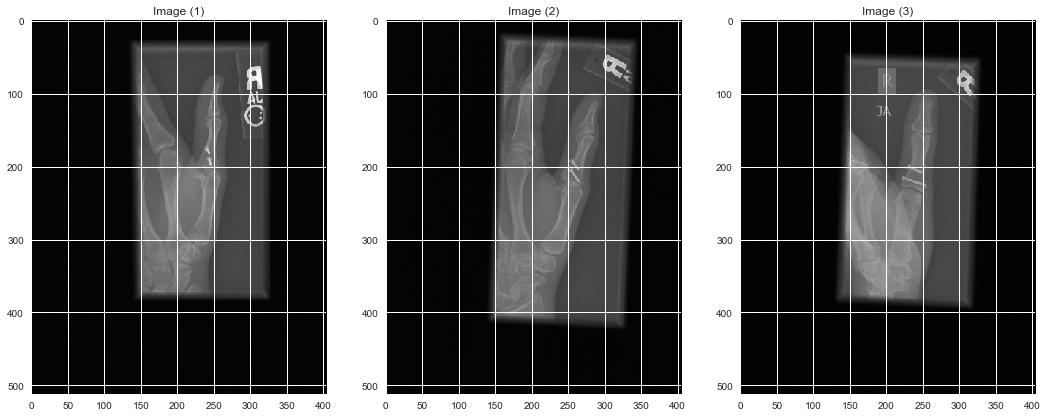

In [66]:
l=train_labels.iloc[2000]['Train Labeled Studies']
images=fileImagesOfStudy(l)
show_images(images)

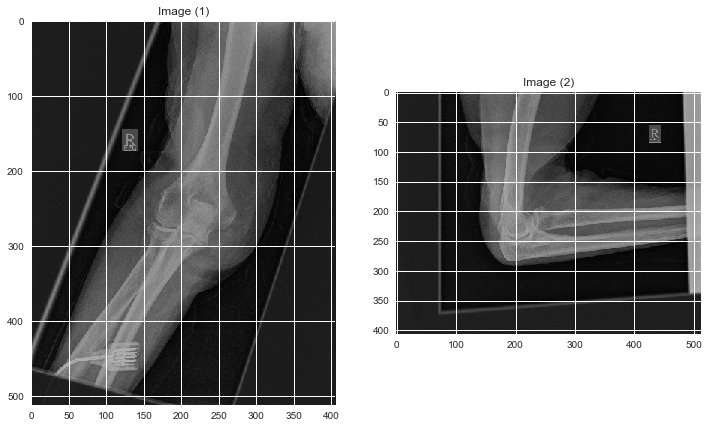

In [67]:
l=train_labels.iloc[3]['Train Labeled Studies']
images=fileImagesOfStudy(l)
show_images(images)

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
%matplotlib inline
plt.style.use("seaborn")

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import regularizers
from keras import applications
from keras import backend as K
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
%matplotlib inline
from matplotlib import pyplot as plt

In [70]:
def prepareDataVGG(className):
    reszizing_Dim=(60,60)
    train_= train_labels[train_labels['Body Part'] ==className]
    test_ = test_labels[test_labels['Body Part'] ==className]
    data__Test=stretching_Data(test_,reszizing_Dim)
    labels_Test=stretching_Labels(test_)
    data__Train=stretching_Data(train_,reszizing_Dim)
    labels_Train=stretching_Labels(train_)
    data__Test=np.asarray(data__Test)
    labels_Test=np.asarray(labels_Test)
    data__Train=np.asarray(data__Train)
    labels_Train=np.asarray(labels_Train)

    return data__Train,labels_Train,data__Test,labels_Test

In [121]:
def prepareDataMobile(className):
    reszizing_Dim=(224,224)
    train_= train_labels[train_labels['Body Part'] ==className]
    test_ = test_labels[test_labels['Body Part'] ==className]
    data__Test=stretching_Data(test_,reszizing_Dim)
    labels_Test=stretching_Labels(test_)
    data__Train=stretching_Data(train_,reszizing_Dim)
    labels_Train=stretching_Labels(train_)
    data__Test=np.asarray(data__Test)
    labels_Test=np.asarray(labels_Test)
    data__Train=np.asarray(data__Train)
    labels_Train=np.asarray(labels_Train)

    return data__Train,labels_Train,data__Test,labels_Test

In [80]:
def vgg19Model(data__Train,labels_Train,data__Test,labels_Test):

    vgg19 = applications.VGG19(include_top=False, weights='imagenet', input_shape=data__Train.shape[1:])
    vgg_model = Sequential()
    vgg_model.add(vgg19)
    vgg_model.add(Flatten())
    vgg_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    vgg_model.add(Dropout(0.5))
    vgg_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    vgg_model.add(Dropout(0.5))
    vgg_model.add(Dense(1, activation='sigmoid'))
    vgg_model.layers[0].trainable = False
    vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history_vgg19 = vgg_model.fit(data__Train, labels_Train, epochs=5, batch_size=32, workers=10, validation_data=(data__Test, labels_Test))
    return history_vgg19,vgg_model

In [74]:
def plotingModel(history_):

    plt.plot(history_.history['loss'])
    plt.plot(history_.history['val_loss'])
    plt.title("Train vs Validation Loss")
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.grid(False)

    plt.legend(['train', 'test'], loc='upper right')

In [95]:
def plotResults(data__Test,labels_Test,vgg_model):
    test_loss, test_acc = vgg_model.evaluate(data__Test, labels_Test, batch_size=100)
    print("Loss on test set: ", test_loss)
    print("Accuracy on test set: ", test_acc)
    test_logits = vgg_model.predict(data__Test, batch_size=10)
    cm  = confusion_matrix(labels_Test, np.round(test_logits))
    plt.figure()
    plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Oranges)
    plt.xticks(range(2), ['Normal', 'Abnromal'], fontsize=16)
    plt.yticks(range(2), ['Normal', 'Abnormal'], fontsize=16)
    plt.show()
    true_negative, false_positive, false_negative, true_positive  = cm.ravel()
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)

    print('Precison of MURA for Abnormal:{:.2f}'.format(precision))
    print('Recall of MURA for Abnormal:{:.2f}'.format(recall))
    num_test = 15
    predictions = vgg_model.predict(data__Test[:num_test,:,:,:])
    for i in range(num_test):
        if predictions[i] <test_acc:
            print("Predicted: Abnormal ",predictions[i])
        else:
            print("predicted: Normal",predictions[i])
        plt.imshow(data__Test[i])
        plt.grid(False)

        plt.show()
    return test_acc
   

In [141]:
def vgg19Model(data__Train,labels_Train,data__Test,labels_Test):

    vgg19 = applications.VGG19(include_top=False, weights='imagenet', input_shape=data__Train.shape[1:])
    vgg_model = Sequential()
    vgg_model.add(vgg19)
    vgg_model.add(Flatten())
    vgg_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    vgg_model.add(Dropout(0.5))
    vgg_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    vgg_model.add(Dropout(0.5))
    vgg_model.add(Dense(1, activation='sigmoid'))
    vgg_model.layers[0].trainable = False
    vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history_vgg19 = vgg_model.fit(data__Train, labels_Train, epochs=5, batch_size=32, workers=10, validation_data=(data__Test, labels_Test))
    return history_vgg19,vgg_model

In [ ]:
elbowClass='ELBOW'
dataElbow__Train_,labelsElbow_Train,dataElbow__Test,labelsWlbow_Test=prepareData(elbowClass)
historyElbow,modelElbow=vgg19Model(dataElbow__Train_,labelsElbow_Train,dataElbow__Test,labelsWlbow_Test)
plotingModel(historyElbow)
test_accElbow=plotResults(dataElbow__Test,labelsWlbow_Test,modelElbow)

In [ ]:
fingerClass='FINGER'
dataFinger__Train_,labelsFinger_Train,dataFinger__Test,labelsFinger_Test=prepareData(fingerClass)
historyFinger,modelFinger=vgg19Model(dataFinger__Train_,labelsFinger_Train,dataFinger__Test,labelsFinger_Test)
plotingModel(historyFinger)
test_accFinger=plotResults(dataFinger__Test,labelsFinger_Test,modelFinger)

In [ ]:
armClass='FOREARM'
dataArm__Train_,labelsArm_Train,dataArm__Test,labelsArm_Test=prepareData(armClass)
historyArm,modelArm=vgg19Model(dataArm__Train_,labelsArm_Train,dataArm__Test,labelsArm_Test)
plotingModel(historyArm)
test_accArm=plotResults(dataArm__Test,labelsArm_Test,modelArm)

In [ ]:
handClass='HAND'
dataHand__Train_,labelsHand_Train,dataHand__Test,labelsHand_Test=prepareData(handClass)
historyHand,modelHand=vgg19Model(dataHand__Train_,labelsHand_Train,dataHand__Test,labelsHand_Test)
plotingModel(historyHand)
test_accHand=plotResults(dataHand__Test,labelsHand_Test,modelHand)

In [ ]:
humerusClass='HUMERUS'
dataHumerus__Train_,labelsHumrus_Train,dataHumerus__Test,labelsHumerus_Test=prepareData(humerusClass)
historyHumerus,modelHumerus=vgg19Model(dataHumerus__Train_,labelsHumrus_Train,dataHumerus__Test,labelsHumerus_Test)
plotingModel(historyHumerus)
test_accHmerus=plotResults(dataHumerus__Test,labelsHumerus_Test,modelHumerus)

In [ ]:
shoulderClass='SHOULDER'
dataShoulder__Train_,labelsShoulder_Train,dataShoulder__Test,labelsShoulder_Test=prepareData(shoulderClass)
historyShoulder,modelShoulder=vgg19Model(dataShoulder__Train_,labelsShoulder_Train,dataShoulder__Test,labelsShoulder_Test)
plotingModel(historyShoulder)
test_accShoulder=plotResults(dataShoulder__Test,labelsShoulder_Test,modelShoulder)

In [ ]:
wristClass='WRIST'
dataWrist__Train_,labelsWrist_Train,dataWrist__Test,labelsWrist_Test=prepareData(wristClass)
historyWrist,modelWrist=vgg19Model(dataWrist__Train_,labelsWrist_Train,dataWrist__Test,labelsWrist_Test)
plotingModel(historyWrist)
test_accWrist=plotResults(dataWrist__Test,labelsWrist_Test,modelWrist)

In [109]:
import cv2
import numpy as np
import tensorflow as tf
import keras
from keras import backend as K
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D,Dropout,SeparableConv2D,BatchNormalization, Activation, Dense
from keras.applications.mobilenet import MobileNet
from keras.optimizers import Adam

In [154]:
from keras import regularizers

def mobileNet_Model(data__Train,labels_Train,data__Test,labels_Test):

    base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224,224,3))
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(256,activation='relu',kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01))(x)
    x = Dropout(0.5)(x)
    x=Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01))(x) 
    x = Dropout(0.5)(x)
    preds=Dense(1, activation='softmax')(x)
    model=Model(inputs=base_model.input,outputs=preds)
    for layer in model.layers[:83]:
        layer.trainable=False
    for layer in model.layers[83:]:
        layer.trainable=True
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    history = model.fit(data__Train, labels_Train, epochs=5, batch_size=32, workers=10, validation_data=(data__Test, labels_Test))
    return history, model

In [133]:
elbowClass='ELBOW'
dataElbow__Train_mobile,labelsElbow_Train_mobile,dataElbow__Test_mobile,labelsWlbow_Test_mobile=prepareDataMobile(elbowClass)

100%|██████████| 1754/1754 [01:01<00:00, 28.37it/s]


In [ ]:
historyMobile, modelMobile=mobileNet_Model(dataElbow__Train_mobile,labelsElbow_Train_mobile,dataElbow__Test_mobile,labelsWlbow_Test_mobile)